In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import io
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import numpy as np
from torchvision import transforms
from transformers import CLIPModel, AutoProcessor
import lpips

base = "/users/aparasel/scratch/magicbrush/downloads" #Set this to ur hugging face download location
n = 50 # ADD IMAGES FROM FIRST N PARQUET FILES
valid_paths = []
for root, _, files in os.walk(base):
    for name in files:
        path = os.path.join(root, name)

        if os.path.getsize(path) < 1024:
            continue
        try:
            pq.ParquetFile(path)      # just to validate
            valid_paths.append(path)
            if len(valid_paths) == n:
                break
        except Exception:
            pass
    if len(valid_paths) == n:
        break

print(f"First {n} parquet-like files:")
for p in valid_paths:
    print(" -", p)

dfs = [pd.read_parquet(p, engine="pyarrow") for p in valid_paths]
df = pd.concat(dfs, ignore_index=True)
print(f"\nLoaded {len(df):,} rows from {len(valid_paths)} files")
print(df.head())


First 50 parquet-like files:
 - /users/aparasel/scratch/magicbrush/downloads/0169b0f6ff2278a2962791f8241d0396be45ed103a82990fa14905de3aa67abe
 - /users/aparasel/scratch/magicbrush/downloads/0b09871001c302254de043cfbcc7bc8b2a0b5d36ca9365b8454b951242f2587e
 - /users/aparasel/scratch/magicbrush/downloads/0e6e63115db8358ddf826ae0f8d05ab5a0e7f77255f8296304309a6217f627ef
 - /users/aparasel/scratch/magicbrush/downloads/0fd1d9cbb860189150e876760d943419107010d622ca636942020febd8fc79f6
 - /users/aparasel/scratch/magicbrush/downloads/1216a5d7d4381f35e457d18241c822933e7ab753e7ef967adaefb1e1a4a01cd1
 - /users/aparasel/scratch/magicbrush/downloads/1262863efbf49a2d74b2d3fbb076716bbd6c0cbcdbdcf964648bab770f48fd42
 - /users/aparasel/scratch/magicbrush/downloads/1267ca9d4bba2198b908ea0acd825c4aca50e1da12386694de590a95d07660c1
 - /users/aparasel/scratch/magicbrush/downloads/13b20d49716c74009054e1cf99853d24335918610e0347f0399aecad714566b6
 - /users/aparasel/scratch/magicbrush/downloads/14bbe8cef2f6c2ac801

In [2]:

df_clean = df
t1 = df_clean[df_clean["turn_index"] == 1][["img_id", "source_img", "instruction"]].rename(
    columns={"source_img": "source_img_t1", "instruction": "instruction_t1"}
)
t2 = df_clean[df_clean["turn_index"] == 2][["img_id", "target_img", "instruction"]].rename(
    columns={"target_img": "target_img_t2", "instruction": "instruction_t2"}
)

merged = t1.merge(t2, on="img_id", how="inner")

# Build final output
merged["instruction"] = merged["instruction_t1"] + " and " + merged["instruction_t2"]

result_df = merged[["img_id", "source_img_t1", "target_img_t2", "instruction"]].rename(
    columns={"source_img_t1": "source_img", "target_img_t2": "target_img"}
)

print(result_df.head())
print(f"Size of dataset is {result_df.shape}")

   img_id                                         source_img  \
0  551188  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  165884  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  426370  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  261161  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  309322  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                          target_img  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                         instruction  
0  add a guide dog and replace a bag with a yello...  
1  Remove the pears and Turn the bowl into a cutt...  
2  turn the shoes into brown boots and let the bu...  
3  Change the bench to a swingset. and Get rid of...  
4  

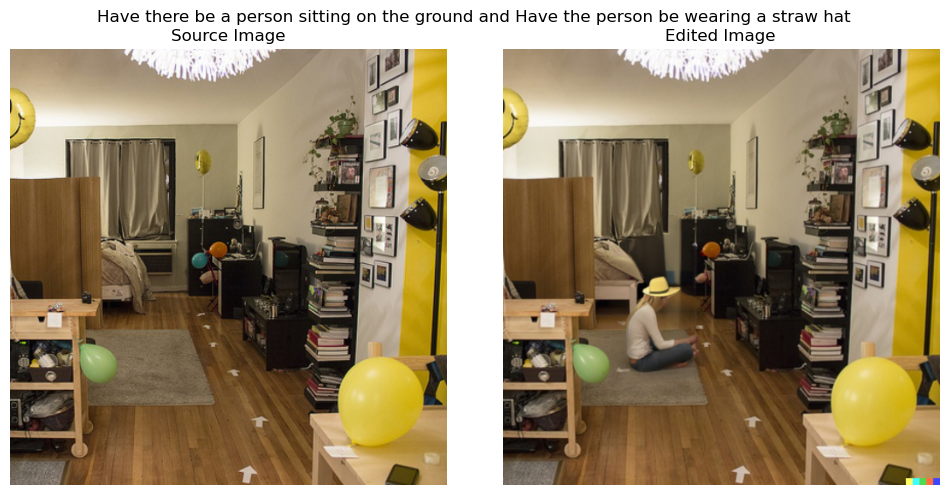

In [3]:
import io
from PIL import Image
import matplotlib.pyplot as plt

row = result_df.iloc[44]

# Decode image bytes
source = Image.open(io.BytesIO(row['source_img']['bytes']))
target = Image.open(io.BytesIO(row['target_img']['bytes']))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(source)
axes[0].set_title("Source Image")
axes[0].axis("off")

axes[1].imshow(target)
axes[1].set_title("Edited Image")
axes[1].axis("off")

plt.suptitle(row['instruction'], wrap=True)
plt.tight_layout()
plt.show()


In [4]:
# =========================
# MagicBrush edit scoring: CLIPScore + DirectionalCLIP + LPIPS
# =========================
# Requirements (once in your env):
#   pip install "transformers>=4.40" lpips torch torchvision pillow



# ------------------------
# Config
# ------------------------
CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8                   # adjust for your GPU memory
ALPHA = 3.0                      # for S_pres = exp(-ALPHA * LPIPS)
W_ALIGN, W_DIR, W_PRES = 0.20, 0.70, 0.10   # weights (sum to 1.0 here)
RESIZE_HW = (256, 256)          # common HxW for LPIPS (e.g., 224, 256, 384)

# ------------------------
# Load models
# ------------------------
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE).eval()
clip_proc  = AutoProcessor.from_pretrained(CLIP_MODEL_NAME)

lpips_fn = lpips.LPIPS(net='alex').to(DEVICE).eval()  # fast & robust

# ------------------------
# Utilities
# ------------------------
def dictbytes_to_pil(img_obj):
    # img_obj is like {'bytes': b'...'}
    return Image.open(io.BytesIO(img_obj["bytes"])).convert("RGB")

def clip_embed_images(pil_images):
    with torch.no_grad():
        inputs = clip_proc(images=pil_images, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        img_feat = clip_model.get_image_features(**inputs)
        img_feat = img_feat / img_feat.norm(p=2, dim=-1, keepdim=True)
    return img_feat  # [B, D], L2-normalized

def clip_embed_text(texts):
    with torch.no_grad():
        inputs = clip_proc(text=texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        txt_feat = clip_model.get_text_features(**inputs)
        txt_feat = txt_feat / txt_feat.norm(p=2, dim=-1, keepdim=True)
    return txt_feat  # [B, D], L2-normalized

def cosine_sim(a, b):
    # a,b are unit vectors
    return (a * b).sum(dim=-1)

def to_01_from_cos(x):
    # map cosine from [-1,1] -> [0,1]
    return (x + 1.0) / 2.0

# For LPIPS we ensure consistent spatial size per batch
to_lpips = transforms.Compose([
    transforms.Resize(RESIZE_HW, interpolation=Image.BICUBIC),
    transforms.ToTensor(),  # [0,1]
])

def pil_to_lpips_tensor(pil_img):
    t = to_lpips(pil_img) * 2.0 - 1.0   # -> [-1,1]
    return t.unsqueeze(0).to(DEVICE)    # [1,3,H,W]

# ------------------------
# Core scoring for one batch
# ------------------------
def score_batch(rows):
    """
    rows: list of (source_pil, target_pil, instruction)
    returns dict of numpy arrays keyed by metrics
    """
    src_imgs = [r[0] for r in rows]
    tgt_imgs = [r[1] for r in rows]
    texts    = [r[2] for r in rows]

    # 1) CLIP embeddings
    img_src_feat = clip_embed_images(src_imgs)
    img_tgt_feat = clip_embed_images(tgt_imgs)
    txt_feat     = clip_embed_text(texts)

    # CLIPScore
    s_align_cos = cosine_sim(img_tgt_feat, txt_feat)         
    s_align     = to_01_from_cos(s_align_cos)              

    # (b) Directional CLIP score
    delta = img_tgt_feat - img_src_feat
    delta = delta / (delta.norm(p=2, dim=-1, keepdim=True) + 1e-8)
    s_dir_cos = cosine_sim(delta, txt_feat)                  
    s_dir     = to_01_from_cos(s_dir_cos)                 

    # 2) Preservation
    src_t = torch.cat([pil_to_lpips_tensor(p) for p in src_imgs], dim=0)  
    tgt_t = torch.cat([pil_to_lpips_tensor(p) for p in tgt_imgs], dim=0)
    with torch.no_grad():
        lp = lpips_fn(src_t, tgt_t)   
    lp = lp.view(-1)                   
    s_pres = torch.exp(-ALPHA * lp)   

    # 3) Final weighted score
    s_final = (W_ALIGN * s_align) + (W_DIR * s_dir) + (W_PRES * s_pres)

    # To CPU numpy
    out = {
        "S_align": s_align.detach().cpu().numpy(),
        "S_dir":   s_dir.detach().cpu().numpy(),
        "LPIPS":   lp.detach().cpu().numpy(),
        "S_pres":  s_pres.detach().cpu().numpy(),
        "S_final": s_final.detach().cpu().numpy(),
    }
    return out


def score_results_df(results_df, max_rows=None, batch_size=BATCH_SIZE):
    df = results_df if max_rows is None else results_df.head(max_rows)

    scores = {k: [] for k in ["S_align", "S_dir", "LPIPS", "S_pres", "S_final"]}
    batch, kept_idx = [], []

    for idx, row in df.iterrows():
        try:
            src_pil = dictbytes_to_pil(row["source_img"])
            tgt_pil = dictbytes_to_pil(row["target_img"])
            text    = str(row["instruction"])
            batch.append((src_pil, tgt_pil, text))
            kept_idx.append(idx)
        except Exception as e:
            print(f"[warn] skipping idx={idx}: {e}")
            continue

        if len(batch) == batch_size:
            out = score_batch(batch)
            for k in scores:
                scores[k].extend(out[k])
            batch, kept_idx = [], []

    if batch:
        out = score_batch(batch)
        for k in scores:
            scores[k].extend(out[k])

    n = len(scores["S_final"])
    df_scored = df.iloc[:n].copy().reset_index(drop=True)
    for k in scores:
        df_scored[k] = scores[k][:n]

    return df_scored




/users/aparasel/.conda/envs/run-qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/users/aparasel/.conda/envs/run-qwen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/aparasel/.conda/envs/run-qwen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/aparasel/.conda/envs/run-qwen/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
df_scored = score_results_df(result_df, max_rows=5000, batch_size=64)
print(df_scored.sort_values("S_final", ascending=False).head(10))

      img_id                                         source_img  \
12     76588  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1382   18893  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1509  335887  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1322  416049  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1994  482452  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
712   581637  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
273   219565  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
160   133819  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1633  453050  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2329  581709  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                             target_img  \
12    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1382  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1509  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1322  {'bytes': b'\x89PNG\

In [6]:
df_scored

,img_id,source_img,target_img,instruction,S_align,S_dir,LPIPS,S_pres,S_final
0,551188,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,add a guide dog and replace a bag with a yello...,0.605567,0.510710,0.084985,0.774951,0.556105
1,165884,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Remove the pears and Turn the bowl into a cutt...,0.585151,0.448368,0.326191,0.375847,0.468473
2,426370,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,turn the shoes into brown boots and let the bu...,0.612338,0.546866,0.259554,0.459020,0.551176
3,261161,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the bench to a swingset. and Get rid of...,0.625495,0.525238,0.308027,0.396896,0.532455
4,309322,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,change 66 to 88 and let the car be red,0.607333,0.552064,0.059981,0.835318,0.591443
...,...,...,...,...,...,...,...,...,...
2613,136,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,make the people point at the giraffe and let t...,0.643471,0.562398,0.072928,0.803495,0.602722
2614,226455,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the young man wear white shoes and let the...,0.581942,0.510329,0.080061,0.786484,0.552267
2615,144706,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the street light be yellow and add a woman...,0.625202,0.579590,0.049753,0.861346,0.616888
2616,465559,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Only one bear should be visible. and There sho...,0.623269,0.547524,0.216637,0.522092,0.560130


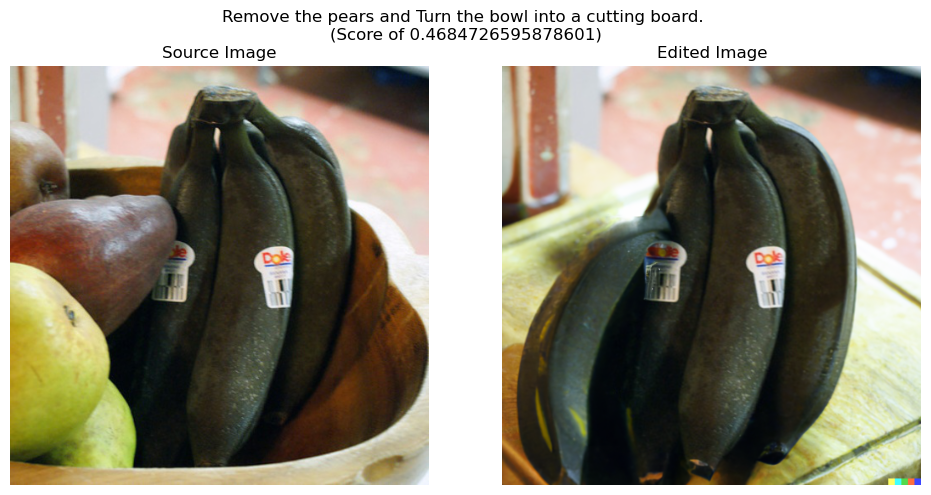

In [7]:

i = 1
row = df_scored.iloc[i]
source = Image.open(io.BytesIO(row['source_img']['bytes']))
target = Image.open(io.BytesIO(row['target_img']['bytes']))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(source)
axes[0].set_title("Source Image")
axes[0].axis("off")

axes[1].imshow(target)
axes[1].set_title("Edited Image")
axes[1].axis("off")

plt.suptitle(str(row['instruction']) + f" \n(Score of {df_scored.iloc[i]['S_final']})", wrap=True)
plt.tight_layout()
plt.show()


In [8]:
filtered_df = df_scored[df_scored['LPIPS'] > 0.11]
filtered_df

,img_id,source_img,target_img,instruction,S_align,S_dir,LPIPS,S_pres,S_final
1,165884,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Remove the pears and Turn the bowl into a cutt...,0.585151,0.448368,0.326191,0.375847,0.468473
2,426370,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,turn the shoes into brown boots and let the bu...,0.612338,0.546866,0.259554,0.459020,0.551176
3,261161,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the bench to a swingset. and Get rid of...,0.625495,0.525238,0.308027,0.396896,0.532455
5,411478,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the pizza to plain cheese. and Change t...,0.642634,0.523197,0.116833,0.704337,0.565198
6,514217,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,put Jessica Rabbit on the pedestal to the righ...,0.621774,0.556915,0.159679,0.619379,0.576133
...,...,...,...,...,...,...,...,...,...
2610,416739,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,place a mattress on the frame and put a spider...,0.624367,0.545858,0.221125,0.515110,0.558485
2611,220948,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the pizza have blue olives on it and let t...,0.609587,0.503347,0.304319,0.401335,0.514394
2612,507037,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the people wear hats and let the building ...,0.598763,0.538769,0.236661,0.491653,0.546056
2616,465559,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Only one bear should be visible. and There sho...,0.623269,0.547524,0.216637,0.522092,0.560130


/users/aparasel/.conda/envs/run-qwen/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


HF_HOME = /users/aparasel/scratch/hf_cache
HF_TOKEN length = 37


Fetching 73 files:   7%|▋         | 5/73 [00:01<00:22,  3.08it/s]

  2025-11-05T00:41:13.579859Z  WARN  Reqwest(reqwest::Error { kind: Request, url: "https://transfer.xethub.hf.co/xorbs/default/4763cdf3c09afc86e2d448850ec624c90ba964f39d6134b26f0484a39a9c931a?X-Xet-Signed-Range=bytes%3D0-57493627&X-Xet-Session-Id=01K98QBAM4RAQ291F3DHH7MV3X&Expires=1762306858&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC80NzYzY2RmM2MwOWFmYzg2ZTJkNDQ4ODUwZWM2MjRjOTBiYTk2NGYzOWQ2MTM0YjI2ZjA0ODRhMzlhOWM5MzFhP1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDAtNTc0OTM2MjcmWC1YZXQtU2Vzc2lvbi1JZD0wMUs5OFFCQU00UkFRMjkxRjNESEg3TVYzWCIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc2MjMwNjg1OH19fV19&Signature=coEFQH4wep53GtvhMTBvPOWzO-OZ-eHROQ15V8HsaDZAiMl0BqpyAErTWdP4OnA63hYV3Ptm0LIxP3hy2AU1E8gR1fTN-RZFJ-iNl6nyjVjkmVLK9OU9TH6I3X3hZ7UWvBIqnSYcl9AVVu7oA-xNbHfkk8iwaQ5r1EPazrX7uxP2MYbMJNEgB0nbMCDUhGtBLjuxO-WIXxuw8OcoImwGhdg6frM-2saO~cTyzsnCsAWAWJLjGSdbjVqBMdAkHTtegqN72AYeObeeu0sgtE83xJ4xcj91hRGV2U1LSkx0pX3QvipCu0XGM0wZ5XnuB

Cancellation requested; stopping current tasks.
Fetching 73 files:  14%|█▎        | 10/73 [09:52<1:02:14, 59.28s/it]


KeyboardInterrupt: 